<a href="https://colab.research.google.com/github/ValenzuelaDiego/proyectoInteligenciaArtificial/blob/main/PenduloInvertidoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_03_keras_reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applicaciones de Deep Neural Networks

# Google CoLab Instructions

El siguiente codigo se asegura que Google Colab esta corriendo la version correcta de TensorFlow.

In [ ]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


In [ ]:
if COLAB:
  !sudo apt-get install -y xvfb ffmpeg x11-utils
  #!pip install -q 'gym==0.10.11'
  !pip install -q 'gym==0.17.0'
  !pip install -q 'imageio==2.4.0'
  #!pip install -q 'imageio==0.2.7'
  !pip install -q PILLOW
  #!pip install -q 'pyglet==1.3.2'
  !pip install -q 'pyglet==1.5.0'
  !pip install -q pyvirtualdisplay
  !pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


# Part 12.3: Keras Q-Learning in the OpenAI Gym

Q-Learning, como cubrimos en la parte anterior, es un algoritmo robusto de aprendizaje automático. Desafortunadamente, Q-Learning requiere que la Q-table contenga una entrada para cada estado posible que pueda tomar el entorno. Si el entorno solo incluye un puñado de elementos de estado discretos, entonces el 
Q-learning tradicional podría ser un buen algoritmo de aprendizaje. Sin embargo, si el espacio de estados es grande, la tabla Q puede llegar a ser prohibitivamente grande.

La creación de políticas para grandes espacios estatales es una tarea que Deep Q-Learning Networks (DQN) generalmente puede manejar. A diferencia de una tabla, una red neuronal no requiere que el programa represente cada combinación de estado y acción. Las redes neuronales pueden generalizar estos estados y aprender puntos en común. Un DQN asigna el estado a sus neuronas de entrada y los valores Q de acción a las neuronas de salida. El DQN se convierte efectivamente en una función que acepta el estado y sugiere una acción al devolver la recompensa esperada por cada una de las posibles acciones. Figura 12 DQL muestra la estructura DQN y el mapeo entre estado y acción.


**Figure 12.DQL: Deep Q-Learning (DQL)**
![Deep Q-Learning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/deepqlearning.png "Reinforcement Learning")




Como ilustra este diagrama, el estado del entorno contiene varios elementos. Para el DQN básico, el estado puede ser una combinación de valores continuos y categóricos / discretos. Para el DQN, los elementos de estado discretos que el programa codificaba normalmente como variables ficticias. Las acciones deben ser discretas cuando su programa implemente un DQN. Otros algoritmos admiten salidas continuas, que analizaremos más adelante en este capítulo.


En este capítulo, haremos uso de [TF-Agents](https://www.tensorflow.org/agents) para implementar un DQN para resolver el entorno de poste de carro. TF-Agents facilita el diseño, la implementación y la prueba de nuevos algoritmos RL al proporcionar componentes modulares bien probados que se pueden modificar y ampliar. Permite una rápida iteración de código, con integración de pruebas funcionales y evaluación comparativa.


## DQN and the Cart-Pole Problem

Barto (1983) first described the cart-pole problem. [[Cite:barto1983neuronlike]](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) 

Un carro está conectado a un poste rígido con bisagras. El carro se puede mover libremente solo en el plano vertical del carro / riel. El agente puede aplicar una fuerza implusiva "izquierda" o "derecha" F de una magnitud fija al carro a intervalos de tiempo discretos. El entorno del carro-poste simula la física detrás de mantener el poste en una posición razonablemente vertical en el carro. El entorno tiene cuatro variables de estado:
* $ x $ La posición del carrito en la pista.
* $ \ theta $ El ángulo del poste con la vertical
* $ \ dot {x} $ La velocidad del carrito.
* $ \ dot {\ theta} $ La tasa de cambio del ángulo.

El espacio de acción consta de acciones discretas:
* Aplicar fuerza a la izquierda
* Aplicar fuerza a la derecha

Para aplicar DQN a este problema, debe crear los siguientes componentes para TF-Agents.

* Ambiente
* Agente
* Políticas
* Métricas y Evaluación
* Búfer de reproducción
* Recopilación de datos
* Trainning

Estos componentes son estándar en la mayoría de las implementaciones de DQN. Posteriormente, aplicaremos estos mismos componentes a un juego de Atari, y después de eso, un problema de nuestro diseño. Este ejemplo se basa en el
 [cart-pole tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb) provided for TF-Agents.  Comenzamos importando las bibliotecas de Python necesarias.



In [ ]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [ ]:
# Configure una pantalla virtual para renderizar entornos de OpenAI gym.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameters

Deben definirse varios hiperparámetros. El ejemplo de TF-Agent proporcionó hiperparámetros razonablemente bien ajustados para el cart-pole. 

In [ ]:
# How long should training run?
num_iterations = 20000 
# How many initial random steps, before training start, to
# collect initial data.
initial_collect_steps = 1000   
# How many steps should we run each iteration to collect 
# data from.
collect_steps_per_iteration = 1 
# How much data should we store for training examples.
replay_buffer_max_length = 100000

batch_size = 64  
learning_rate = 1e-3 
# How often should the program provide an update.
log_interval = 200  

# How many episodes should the program use for each evaluation.
num_eval_episodes = 10
# How often should an evaluation occur.
eval_interval = 1000  

## Environment

TF-Agents utiliza entornos de OpenAI gym para representar la tarea o problema a resolver. Se pueden crear entornos estándar en TF-Agents usando **tf_agents.environments** suites. TF-Agents tiene suites para cargar entornos de fuentes como OpenAI Gym, Atari y DM Control. Comenzamos cargando el entorno CartPole desde la suite OpenAI Gym.


In [ ]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)


Rápidamente renderizaremos este entorno para ver la representación visual.


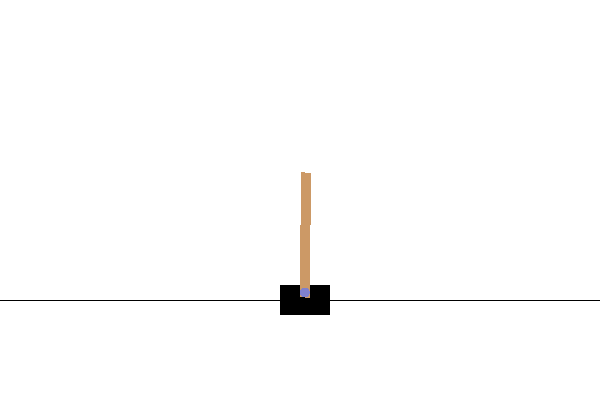

In [ ]:
env.reset()
PIL.Image.fromarray(env.render())

El método `environment.step` toma una` acción` en el entorno y devuelve una tupla de `TimeStep` que contiene la siguiente observación del entorno y la recompensa por la acción.


El método `time_step_spec ()` devuelve la especificación de la tupla `TimeStep`. Su atributo "observación" muestra la forma de las observaciones, los tipos de datos y los rangos de valores permitidos. El atributo "recompensa" muestra los mismos detalles para la recompensa.


In [ ]:
print('Especificaciones de Observacion:')
print(env.time_step_spec().observation)

Especificaciones de Observacion:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [ ]:
print('Especificaciones de las Recompensas:')
print(env.time_step_spec().reward)

Especificaciones de las Recompensas:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


El método `action_spec ()` devuelve la forma, los tipos de datos y los valores permitidos de las acciones válidas.

> Bloque con sangría



In [ ]:
print('Especificaciones de la Accion:')
print(env.action_spec())

Especificaciones de la Accion:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


En el entorno Cartpole:

- `observación` es una matriz de 4 float:
    - la posición y velocidad del carro
    - la posición angular y la velocidad del poste
- `recompensa` es un valor float escalar
- `action` es un entero escalar con solo dos valores posibles:
    - `0` -" mover a la izquierda "
    - `1` -" mover a la derecha "



In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.00336044, -0.03365254, -0.00528065, -0.04748295], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.00268739,  0.16154474, -0.00623031, -0.34182727], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


Por lo general, el programa crea dos entornos: uno para entrenamiento y otro para evaluación.


In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

El entorno Cartpole, como la mayoría de los entornos, está escrito en Python puro y se convierte a TF-Agents y TensorFlow mediante el contenedor **TFPyEnvironment**. La API del entorno original utiliza matrices Numpy. **TFPyEnvironment** los convierte en **Tensores** para que sean compatibles con los agentes y las políticas de Tensorflow.


In [ ]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agente

Un agente representa el algoritmo utilizado para resolver un problema de RL. TF-Agents proporciona implementaciones estándar de una variedad de agentes:

-   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (used in this example)
-   [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
-   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
-   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
-   [PPO](https://arxiv.org/abs/1707.06347)
-   [SAC](https://arxiv.org/abs/1801.01290).

Solo puede utilizar el agente DQN en entornos que tengan un espacio de acción discreto. El DQN hace uso de QNetwork, un modelo de red neuronal que aprende a predecir Q-Values ​​(retornos esperados) para todas las acciones, dado un estado del entorno.

El siguiente código usa **tf_agents.networks.q_network** para crear una QNetwork, pasando la **observación_espec**, **acción_espec** y una tupla que describe el número y tamaño de las capas ocultas del modelo.



In [ ]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

Ahora usamos **tf_agents.agents.dqn.dqn_agent** para instanciar un **DqnAgent**. Además de **time_step_spec**, **action_spec** y QNetwork, el constructor del agente también requiere un optimizador (en este caso, **AdamOptimizer**), una función de pérdida y un contador de pasos de números enteros.


In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Políticas

Una política define la forma en que actúa un agente en un entorno. Normalmente, el objetivo del aprendizaje por refuerzo es entrenar el modelo subyacente hasta que la política produzca el resultado deseado.

En este ejemplo:

* El resultado deseado es mantener el poste equilibrado en posición vertical sobre el carro.
* La política devuelve una acción (izquierda o derecha) para cada observación de "time_step".

Los agentes contienen dos políticas:

* **agent.policy**: el algoritmo utiliza esta política principal para la evaluación y la implementación.
* **agent.collect_policy**: el algoritmo de esta política secundaria para la recopilación de datos.



In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Las políticas se pueden crear independientemente de los agentes. Por ejemplo, use **tf_agents.policies.random_tf_policy** para crear una política que seleccionará aleatoriamente una acción para cada **time_step**. Usaremos esta política aleatoria para crear datos de recopilación inicial para comenzar la capacitación.


In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

Para obtener una acción de una política, llame al método **policy.action (time_step)**. **time_step** contiene la observación del entorno. Este método devuelve un **PolicyStep**, que es una tupla con nombre con tres componentes:
* **action**: la acción que se va a realizar (en este caso, 0 o 1).
* **estado**: se utiliza para políticas con estado (es decir, basadas en RNN).
* **info**: datos auxiliares, como el registro de probabilidades de acciones.

A continuación, creamos un entorno y configuramos la política aleatoria.

In [ ]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))
time_step = example_environment.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

## Métricas y evaluación

La métrica más común utilizada para evaluar una politica es el rendimiento promedio. El retorno es la suma de las recompensas obtenidas al ejecutar una política en un entorno para un episodio. Se ejecutan varios episodios, lo que genera un rendimiento promedio. La siguiente función calcula el rendimiento promedio de una política, dados la política, el entorno y una serie de episodios.


In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations 
# of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

La ejecución de este cálculo en `random_policy` muestra un rendimiento de referencia en el entorno.


In [ ]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

19.4

## Búfer de reproducción

El búfer de reproducción realiza un seguimiento de los datos recopilados del entorno. Este tutorial usa **TFUniformReplayBuffer**. El constructor requiere las especificaciones de los datos que recopilará. Este valor está disponible en el agente mediante el método **collect_data_spec**. También se requieren el tamaño del lote y la longitud máxima del búfer.



In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

Para la mayoría de los agentes, **collect_data_spec** es una tupla con nombre llamada **Trayectoria**, que contiene las especificaciones de observaciones, acciones, recompensas y otros elementos.


In [ ]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

## Recopilación de datos

Ahora ejecute la política aleatoria en el entorno durante algunos pasos, registrando los datos en el búfer de reproducción.


In [ ]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

El búfer de reproducción ahora es una colección de trayectorias. El agente necesita acceso al búfer de reproducción. TF-Agents proporciona este acceso mediante la creación de una canalización **tf.data.Dataset** iterable, que proporcionará datos al agente.

Cada fila del búfer de reproducción solo almacena un único paso de observación. Pero dado que el agente DQN necesita tanto la observación actual como la siguiente para calcular la pérdida, la canalización del conjunto de datos muestreará dos filas adyacentes para cada elemento del lote (**num_steps = 2**).

El programa también optimiza este conjunto de datos mediante la ejecución de llamadas en paralelo y la obtención previa de datos.

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(
{action: (64, 2),
 discount: (64, 2),
 next_step_type: (64, 2),
 observation: (64, 2, 4),
 policy_info: (),
 reward: (64, 2),
 step_type: (64, 2)}), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(
{action: tf.int64,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: tf.float32,
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [ ]:
iterator = iter(dataset)

print(iterator)


## Entrenando al agente

Deben suceder dos cosas durante el ciclo de entrenamiento:

* Recopilar datos del medio ambiente.
* Utilice esos datos para entrenar la (s) red (es) neuronal (es) del agente

Este ejemplo también evalúa periódicamente la política e imprime la puntuación actual.

Lo siguiente tardará ~ 5 minutos en ejecutarse.

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph 
# using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, \
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, \
                                    num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)
    

step = 200: loss = 15.812810897827148
step = 400: loss = 15.685630798339844
step = 600: loss = 14.720613479614258
step = 800: loss = 25.482357025146484
step = 1000: loss = 1.8311368227005005
step = 1000: Average Return = 31.600000381469727
step = 1200: loss = 12.047847747802734
step = 1400: loss = 39.689491271972656
step = 1600: loss = 15.820098876953125
step = 1800: loss = 57.33294677734375
step = 2000: loss = 92.71205139160156
step = 2000: Average Return = 35.400001525878906
step = 2200: loss = 21.785415649414062
step = 2400: loss = 48.07857894897461
step = 2600: loss = 104.7581787109375
step = 2800: loss = 21.354534149169922
step = 3000: loss = 57.412052154541016
step = 3000: Average Return = 89.4000015258789
step = 3200: loss = 60.731468200683594
step = 3400: loss = 97.78526306152344
step = 3600: loss = 38.47401428222656
step = 3800: loss = 11.571377754211426
step = 4000: loss = 203.43771362304688
step = 4000: Average Return = 125.0999984741211
step = 4200: loss = 161.3185577392578

KeyboardInterrupt: ignored

## Visualization


### Plots

Utilice **matplotlib.pyplot** para trazar cómo mejora la política durante el entrenamiento.

Una iteración de **Cartpole-v0** consta de 200 pasos de tiempo. El entorno da una recompensa de `+ 1` por cada paso que el poste permanece derecho, por lo que el retorno máximo para un episodio es 200. Los gráficos muestran el retorno aumentando hacia ese máximo cada vez que se evalúa durante el entrenamiento. (Puede ser un poco inestable y no aumentar cada vez de forma monótona).

(4.174999999999999, 250.0)

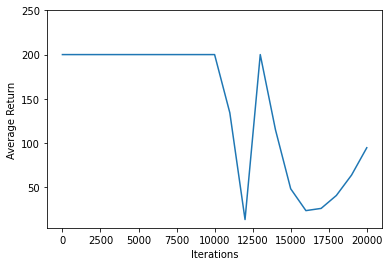

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

### Videos

Los gráficos son agradables. Pero lo más emocionante es ver a un agente realizando una tarea en un entorno.

Primero, cree una función para incrustar videos en el cuaderno.


In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Ahora repite algunos episodios del juego Cartpole con el agente. El entorno de Python subyacente (el que está "dentro" del contenedor de entorno de TensorFlow) proporciona un método `render ()`, que genera una imagen del estado del entorno. Estos se pueden recopilar en un video.

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")

Para divertirse, compare al agente entrenado (arriba) con un agente que se mueve al azar. (No funciona tan bien).


In [ ]:
create_policy_eval_video(random_policy, "random-agent")